In [ ]:


def highlight_estimated_cell_box(base_img_path, label_paths, save_path, choice="A", bb_type="static"):
    for label_path in label_paths:
        # the columns I need are: TMA_AB, Region, X_withinTile:X_withinTile, Y_withinTile:Y_withinTile,
        # and size:size
        label_i = f"{label_path}/patients_{label_path[97:]}_ct_labels_{choice}.csv"
        df = pd.read_csv(label_i)
        img_file_names = list(set(df["File Name"]))

        for img_file_name in img_file_names:
            img_file = base_img_path + "/" + img_file_name + ".tif"
            base_img = np.array(Image.open(img_file)) # since I use pillow to open, just use it to save it

            # get cell coords, and draw bounding boxes now.
            df_new = df[df['File Name'] == (img_file_name)]
            x = df_new["X_withinTile:X_withinTile"].to_numpy()
            y = df_new["Y_withinTile:Y_withinTile"].to_numpy()

            cell_sizes = df_new["size:size"].to_numpy()

            if bb_type == "static":
                cell_rad = int(np.floor(np.sqrt(np.mean(0.14246*cell_sizes)) / 2))

            num_cells = len(x)

            # cells to create boxes:
            chosen_cells = np.arange(num_cells)
            np.random.shuffle(chosen_cells)
            chosen_cells = chosen_cells[:60]

            for i in chosen_cells:
                x_coord_j = x[i]
                y_coord_i = y[i]

                if bb_type != "static":
                    cell_rad = int(np.floor(np.sqrt(0.14246*cell_sizes[i]) / 2))

                cell_box_slice = np.copy(base_img[(y_coord_i-cell_rad) + 2:(y_coord_i+cell_rad+1) - 2,
                                         (x_coord_j-cell_rad) + 2:(x_coord_j+cell_rad+1) - 2])
                base_img[(y_coord_i - cell_rad):(y_coord_i + cell_rad + 1),
                (x_coord_j - cell_rad):(x_coord_j + cell_rad + 1)] = 0
                base_img[(y_coord_i - cell_rad) + 2:(y_coord_i + cell_rad + 1) - 2,
                (x_coord_j - cell_rad) + 2:(x_coord_j + cell_rad + 1) - 2] = cell_box_slice
                base_img[y_coord_i-1:y_coord_i+2, x_coord_j-1:x_coord_j+2] = 50

            # now save the base_img
            saved_image = Image.fromarray(base_img)

            if bb_type == "static":
                saved_image.save(f"{save_path}/Static/{img_file_name}_bb_test.tif")
            else:
                saved_image.save(f"{save_path}/Adaptive/{img_file_name}_bb_test.tif")

    return ""


def get_bb_test_imgs(label_path, img_path, save_path):
    paths = []
    for subdir, dirs, files in os.walk(label_path):
        if subdir != label_path:
            paths.append(subdir)

    chosen_patients = [0, 1, 11, 13, 15, 19, 21, 24, 30, 33]

    chosen_paths = [paths[i] for i in chosen_patients]
    # print(chosen_paths)
    highlight_estimated_cell_box(img_path, chosen_paths, save_path, choice="A", bb_type="Adaptive")

    return paths

In [9]:
import numpy as np
import pandas as pd
from PIL import Image
import os
from functools import partial
import matplotlib.pyplot as plt

In [5]:
FOLDER_PATH = 'C:/Users/aqwan/cancer_center_data_processing/processed_image_labels_cancer_center_nodirt'
IMG_PATH = 'C:/Users/aqwan/cancer_center_data_processing'
SAVE_PATH = 'C:/Users/aqwan/cancer_center_data_processing/cellsighter_processed'

In [6]:
def split_labels(label_path, category="A"):

    # dir_name = ""
    # os.makedirs(dir_name, exist_ok=True)
    paths=[]
    df_new = None
    # i = 1
    for subdir, dirs, files in os.walk(label_path):
        if subdir != label_path:
            paths.append(subdir)
            for file in files:
                file_path = os.path.join(subdir, file)
                # print(file[:-6])
                # print(file_path)
                df = pd.read_csv(file_path)
                df_new = df[df['TMA_AB'] == category]
                # df_new.to_csv(subdir + "/" + file[:-6] + f"{category}.csv")
            os.remove(subdir + "/" + file[:-6] + f"{category}.csv")
            # i = i + 1

    return paths, df_new

In [7]:
def ct_mapping(value):
    mapping = {
        "granulocytes": 0,
        "vasculature": 1,
        "CD4+ T cells CD45RO+": 2,
        "tumor cells": 3,
        "stroma": 4,
        "CD68+CD163+ macrophages": 5,
        "adipocytes": 6,
        "plasma cells": 7,
        "CD8+ T cells": 8,
        "Tregs": 9,
        "CD4+ T cells": 10,
        "CD11c+ DCs": 11,
        "B cells": 12,
        "CD11b+CD68+ macrophages": 13,
        "smooth muscle": 14,
        "undefined": 15,
        "tumor cells / immune cells": 16,
        "immune cells / vasculature": 17,
        "immune cells": 18,
        "NK cells": 19,
        "nerves": 20,
        "CD68+ macrophages GzmB+": 21,
        "CD68+ macrophages": 22,
        "lymphatics": 23,
        "CD11b+ monocytes": 24,
        "CD4+ T cells GATA3+": 25,
        "CD163+ macrophages": 26,
        "CD3+ T cells": 27
                }

    label = mapping[value]

    return label



In [60]:
def get_cells2labels(df, new_mappings:dict =None):
    # df = pd.read_csv(file_path)

    ct_col = df["ClusterName"]
    ct_col = ct_col.tolist()

    # print(ct_col)
    mapped_ct_label = list(map(ct_mapping, ct_col))

    # add the function for rewriting the cell labels here.
    if new_mappings:
        partial_func = partial(get_new_labels, new_mappings)
        mapped_ct_label = list(map(partial_func, mapped_ct_label))

    return ct_col, mapped_ct_label


def rename_files(file_directory, category="A"):
    for count, filename in enumerate(os.listdir(file_directory)):
        new_name = filename[:6] + f"_{category}.tif"

        src = f"{file_directory}/{filename}"
        dst = f"{file_directory}/{new_name}"

        os.rename(src, dst)
    print(f"Finished renaming category {category} img files.")
    return


def create_cells_img(base_img_path: str, label_paths: str, save_path: str, choice: str ="A", bb_type: str ="static", exclusions: list =None, new_maps: dict =None):
    cells_img = x = y = fixed_cell_labels = cell_ids = None

    df_labels = pd.read_csv(label_paths) # Use the 'File Name' column
    # remove the rows
    if exclusions:
        df_labels = remove_excluded(df_labels, exclusions)

    img_file_names = list(set(df_labels["File Name"]))

    for img_file_name in img_file_names:
        try:
            img_file = base_img_path + "/" + img_file_name + ".tif"

            orig_img = Image.open(img_file)
            img = np.array(orig_img)
            h, w, D = img.shape

            df_new = df_labels[df_labels['File Name'] == (img_file_name)]
            x = df_new["X_withinTile:X_withinTile"].to_numpy()
            y = df_new["Y_withinTile:Y_withinTile"].to_numpy()

            num_cells = len(x)

            cts, mapped_cts = get_cells2labels(df_new, new_mappings=new_maps)
            mapped_cts = np.array(mapped_cts)

            cell_ids = np.arange(1, num_cells + 1)
            cells_img = np.zeros((h, w))

            # I can do it this way, or do different sizes for each cell
            cell_sizes = df_new["size:size"].to_numpy()

            if bb_type == "static":
                cell_rad = int(np.ceil(np.sqrt(np.mean(.14246*cell_sizes)) / 2))

            for i in np.arange(num_cells):
                x_coord_j = x[i]
                y_coord_i = y[i]

                if bb_type != "static":
                    cell_rad = int(np.ceil(np.sqrt(.14246 * cell_sizes[i]) / 2))

                # create the boxes first, then afterwards fill a 10 x 10 box around the center?
                cells_img[(y_coord_i - cell_rad):(y_coord_i + cell_rad + 1),
                (x_coord_j - cell_rad):(x_coord_j + cell_rad + 1)] = cell_ids[i]
                cells_img[(y_coord_i - 5):(y_coord_i + 5 + 1),
                (x_coord_j - 5):(x_coord_j + 5 + 1)] = cell_ids[i]

            fixed_cell_labels = np.zeros(num_cells+1)
            fixed_cell_labels[0] = -1
            fixed_cell_labels[1:] = mapped_cts

            # now save the files
            category = "Adaptive"
            if bb_type == "static":
                category = "Static"

            os.makedirs(save_path + f"/{category}/CellTypes/cells", exist_ok=True)
            np.savez(save_path + f"/{category}/CellTypes/cells/{img_file_name}.npz", data=cells_img)

            os.makedirs(save_path + f"/{category}/CellTypes/cells2labels", exist_ok=True)
            np.savez(save_path + f"/{category}/CellTypes/cells2labels/{img_file_name}.npz", data=fixed_cell_labels)
        except Exception as e:
            print(f"An unexpected error occurred: {e}")

    return cells_img, x, y, fixed_cell_labels, cell_ids


def get_cellsighter_processed_data(label_path, img_path, save_path, choice="A"):
    paths = []
    for subdir, dirs, files in os.walk(label_path):
        if subdir != label_path:
            paths.append(subdir)

    # print(chosen_paths)
    create_cells_img(img_path, paths, save_path, choice=choice, bb_type="Adaptive")

    return paths


In [41]:
# make a new function? or just edit the current
# Rewrite above functions to use just the original whole csv file.
def get_new_labels(new_mapping: dict, old_mapping):

    new_label = new_mapping[old_mapping]

    return new_label


def remove_excluded(df, exclusion_list):
    new_df = df.copy()
    mask = new_df['ClusterName'].isin(exclusion_list)

    # Invert the mask to select rows where 'City' is NOT in cities_to_remove
    new_df = new_df[~mask]

    return new_df

In [64]:
def quick_rename(direct, new_name="A"):
    files = os.listdir(direct)

    for idx, filename in enumerate(files):
        new_file_name = f"{os.path.splitext(filename)[0][0:6]}_{new_name}.tif"

        old_file = os.path.join(direct, filename)
        new_file = os.path.join(direct, new_file_name)

        os.rename(old_file, new_file)

    return None

In [7]:
def get_multiclass_ct_name(label):

    new_mapping = {
        0: "CD4+ T",
        1: "CD8+ T",
        2: "Treg",
        3: "B cells",
        4: "NK Cells",
        5: "Dendritic Cells",
        6: "Monocytes / Macrophages",
        7: "Stromal Cells",
        8: "Smooth Muscle",
        9: "Tumor Cells",
        10: "Vasculature",
        11: "Granulocytes",
    }

    class_name = new_mapping[label]

    return class_name

In [65]:
root_path = "C:/Users/aqwan/Documents/cancer_center_download_locaiton"
img_paths = f"{root_path}/TMA_B_HandE"
label_path = f"{root_path}/CRC_clusters_neighborhoods_markers.csv"

In [66]:
quick_rename(img_paths, new_name="B")

In [67]:
excluded_cts = ["CD3+ T cells", "tumor cells / immune cells", "immune cells / vasculature", "immune cells", "undefined", "dirt"]
# 1, 23, 25, 26, 27

new_ct_groups = [[10, 2, 25], [8], [9], [12, 7], [19], [11], [22, 21, 5, 13, 24, 26], [4, 6, 23, 20], [14], [3], [1], [0]]

ct_dict = {}
for i, ct in enumerate(new_ct_groups):
    new_ct_dict = {key: i for key in ct}
    ct_dict = ct_dict | new_ct_dict


In [68]:
ct_dict

{10: 0,
 2: 0,
 25: 0,
 8: 1,
 9: 2,
 12: 3,
 7: 3,
 19: 4,
 11: 5,
 22: 6,
 21: 6,
 5: 6,
 13: 6,
 24: 6,
 26: 6,
 4: 7,
 6: 7,
 23: 7,
 20: 7,
 14: 8,
 3: 9,
 1: 10,
 0: 11}

In [69]:
saved_path = root_path

ct_imgs, x_coords, y_coords, new_cell_labels, cell_id_list = create_cells_img(img_paths, label_path, saved_path, bb_type="Adaptive", exclusions=excluded_cts, new_maps=ct_dict)

An unexpected error occurred: [Errno 2] No such file or directory: 'C:\\Users\\aqwan\\Documents\\cancer_center_download_locaiton\\TMA_B_HandE\\reg055_A.tif'
An unexpected error occurred: [Errno 2] No such file or directory: 'C:\\Users\\aqwan\\Documents\\cancer_center_download_locaiton\\TMA_B_HandE\\reg013_A.tif'
An unexpected error occurred: [Errno 2] No such file or directory: 'C:\\Users\\aqwan\\Documents\\cancer_center_download_locaiton\\TMA_B_HandE\\reg034_A.tif'
An unexpected error occurred: [Errno 2] No such file or directory: 'C:\\Users\\aqwan\\Documents\\cancer_center_download_locaiton\\TMA_B_HandE\\reg009_A.tif'
An unexpected error occurred: [Errno 2] No such file or directory: 'C:\\Users\\aqwan\\Documents\\cancer_center_download_locaiton\\TMA_B_HandE\\reg050_A.tif'
An unexpected error occurred: [Errno 2] No such file or directory: 'C:\\Users\\aqwan\\Documents\\cancer_center_download_locaiton\\TMA_B_HandE\\reg065_A.tif'
An unexpected error occurred: [Errno 2] No such file or di

In [70]:
new_cell_labels.shape

(1645,)

In [72]:
new_cell_labels[0]

np.float64(-1.0)

# define function for analyzing images and proportions of cell types for each image from the list of labels

In [ ]:
train = ["reg001_A", "reg002_A", "reg003_A", "reg004_A", "reg005_A", "reg006_A", "reg007_A", "reg008_A", "reg009_A", "reg010_A", "reg011_A", "reg012_A", "reg013_A", "reg014_A", "reg015_A", "reg016_A", "reg017_A", "reg018_A", "reg019_A", "reg020_A", "reg021_A", "reg022_A", "reg023_A", "reg024_A", "reg025_A", "reg026_A", "reg027_A", "reg028_A", "reg029_A", "reg030_A", "reg031_A", "reg032_A", "reg033_A", "reg034_A", "reg035_A", "reg036_A", "reg037_A", "reg038_A", "reg039_A", "reg040_A", "reg041_A", "reg042_A", "reg043_A", "reg044_A", "reg045_A", "reg046_A", "reg051_A", "reg052_A", "reg053_A", "reg054_A", "reg055_A", "reg056_A", "reg059_A", "reg060_A", "reg061_A", "reg062_A", "reg063_A", "reg064_A",
         "reg001_B", "reg002_B", "reg003_B", "reg004_B", "reg005_B", "reg006_B", "reg007_B", "reg008_B", "reg009_B", "reg010_B", "reg011_B", "reg012_B", "reg013_B", "reg014_B", "reg015_B", "reg016_B", "reg017_B", "reg018_B", "reg019_B", "reg020_B", "reg021_B", "reg022_B", "reg023_B", "reg024_B", "reg025_B", "reg026_B", "reg027_B", "reg028_B", "reg029_B", "reg030_B", "reg031_B", "reg032_B", "reg033_B", "reg034_B", "reg035_B", "reg036_B", "reg037_B", "reg038_B", "reg039_B", "reg040_B", "reg041_B", "reg042_B", "reg043_B", "reg044_B", "reg045_B", "reg046_B", "reg051_B", "reg052_B", "reg053_B", "reg054_B", "reg055_B", "reg056_B",  "reg059_B", "reg060_B", "reg061_B", "reg062_B", "reg063_B", "reg064_B", ]

val = ["reg047_A", "reg048_A", "reg049_A", "reg050_A", "reg057_A", "reg058_A", "reg065_A", "reg066_A", "reg067_A", "reg068_A",
       "reg047_B", "reg048_B", "reg049_B", "reg050_B", "reg057_B", "reg058_B", "reg065_B", "reg066_B", "reg067_B", "reg068_B"]

In [17]:
import json

In [18]:
JSON_BASE_PATH = 'C:/Users/aqwan/Documents/cancer_center_download_processing'

In [22]:
json_data_path = f"{JSON_BASE_PATH}/training_metrics_results_55epochs.json"

with open(json_data_path, 'r') as file:
    metrics_dict = json.load(file)

In [20]:
json_data_path2 = f"{JSON_BASE_PATH}/training_history_new_55epochs.json"

with open(json_data_path2, 'r') as file2:
    multi_class_aucs = json.load(file2)

used_multi_aucs = multi_class_aucs['val_multi_auc'][-1]

In [12]:
metrics_dict

{'accuracy': 0.3612501577419762,
 'precision_per_class': [0.20338028169014086,
  0.24263221639079532,
  0.02313030069390902,
  0.20507084265473527,
  0.0,
  0.034722222222222224,
  0.2690014903129657,
  0.2062883435582822,
  0.475364712358932,
  0.6516923076923077,
  0.17338403041825096,
  0.22895467160037003],
 'recall_per_class': [0.1935656836461126,
  0.2918892666342885,
  0.14925373134328357,
  0.2506836827711942,
  0.0,
  0.07575757575757576,
  0.09603617983506252,
  0.11982182628062361,
  0.5900239152716091,
  0.6646791150164758,
  0.1930567315834039,
  0.24861878453038674],
 'f1_per_class': [0.19835164835164834,
  0.26499118165784835,
  0.04005340453938585,
  0.22559474979491387,
  0.0,
  0.047619047619047616,
  0.141540874338365,
  0.1515919977458439,
  0.5265243902439024,
  0.6581216499650431,
  0.18269230769230768,
  0.23838189260775344],
 'support_per_class': [1865,
  2059,
  201,
  1097,
  9,
  66,
  3759,
  2245,
  2927,
  6373,
  1181,
  1991],
 'precision_avg': 0.3697608

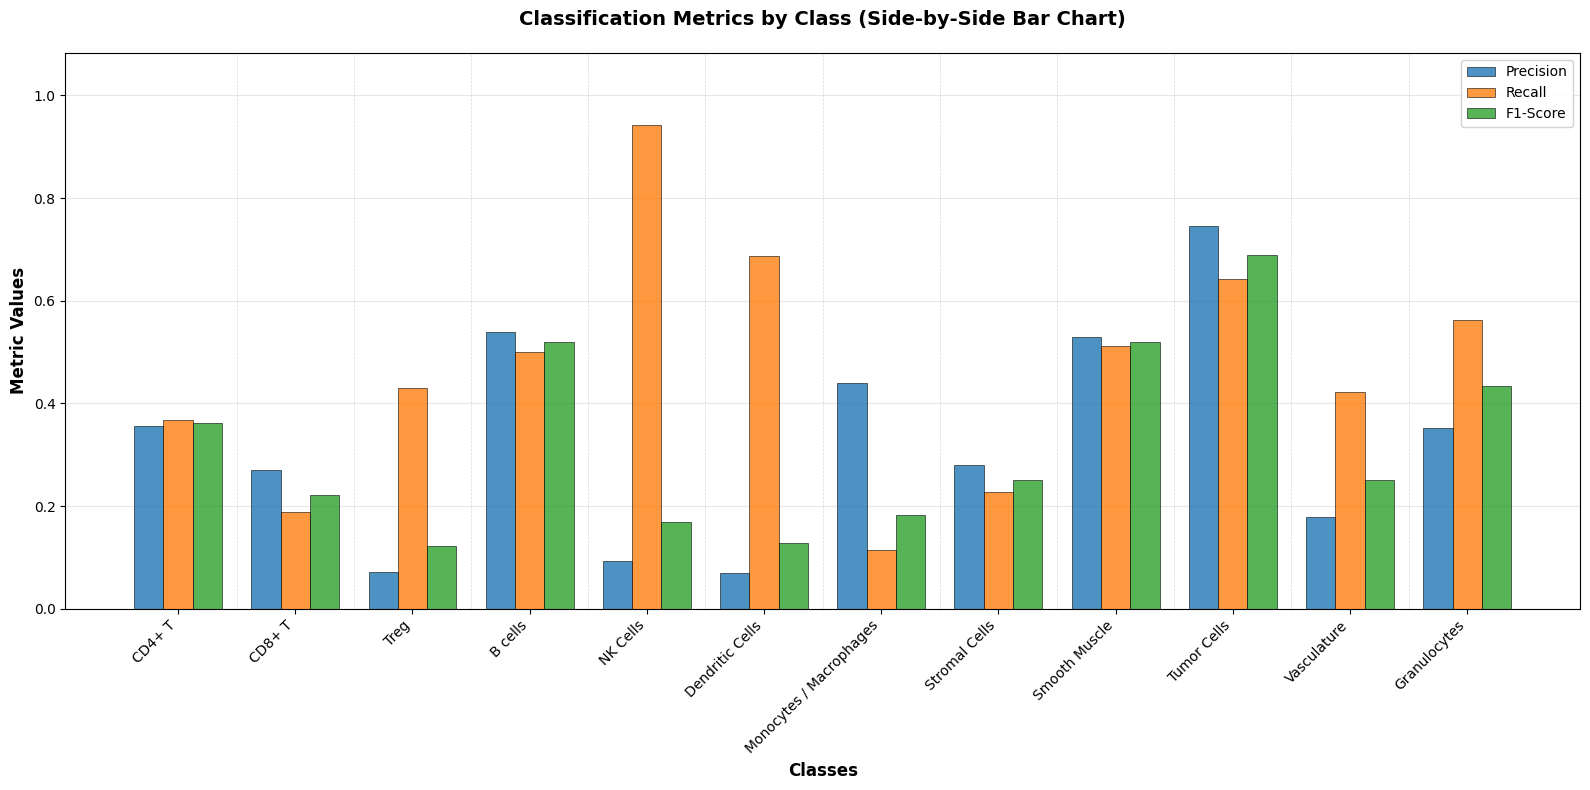

Summary Statistics:
Number of classes: 12
Average Precision: 0.327
Average Recall: 0.466
Average F1-Score: 0.321
Best performing class (by F1): Class 9 (F1: 0.690)
Worst performing class (by F1): Class 2 (F1: 0.123)


In [23]:
# Extract data
precision = metrics_dict['precision_per_class']
recall = metrics_dict['recall_per_class']
f1 = metrics_dict['f1_per_class']

# Number of classes (bars)
n_classes = len(precision)
class_labels = [f'{get_multiclass_ct_name(i)}' for i in range(n_classes)]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(16, 8))

# Set the width of bars and positions for side-by-side layout
bar_width = 0.25
x_pos = np.arange(n_classes)

# Calculate positions for each metric's bars
precision_pos = x_pos - bar_width
recall_pos = x_pos
f1_pos = x_pos + bar_width

# Create side-by-side bars
bars1 = ax.bar(precision_pos, precision, bar_width, label='Precision',
               color='#1f77b4', alpha=0.8, edgecolor='black', linewidth=0.5)
bars2 = ax.bar(recall_pos, recall, bar_width, label='Recall',
               color='#ff7f0e', alpha=0.8, edgecolor='black', linewidth=0.5)
bars3 = ax.bar(f1_pos, f1, bar_width, label='F1-Score',
               color='#2ca02c', alpha=0.8, edgecolor='black', linewidth=0.5)

# Customize the plot
ax.set_xlabel('Classes', fontsize=12, fontweight='bold')
ax.set_ylabel('Metric Values', fontsize=12, fontweight='bold')
ax.set_title('Classification Metrics by Class (Side-by-Side Bar Chart)',
             fontsize=14, fontweight='bold', pad=20)

# Set x-axis labels and positions (centered on the middle bar)
ax.set_xticks(x_pos)
ax.set_xticklabels(class_labels, rotation=45, ha='right')

# Add legend
ax.legend(loc='upper right', framealpha=0.9)

# Add grid for better readability
ax.grid(True, alpha=0.3, axis='y')
ax.set_axisbelow(True)

# Set y-axis limits (0 to 1 for metrics, with some padding)
max_value = max(max(precision), max(recall), max(f1))
ax.set_ylim(0, min(1.1, max_value * 1.15))

# Add value labels on bars
def add_value_labels_side_by_side(bars, values, rotation=90):
    """Add value labels on top of bars for side-by-side layout"""
    for bar, value in zip(bars, values):
        height = bar.get_height()
        if height > 0.02:  # Only show label if bar is tall enough
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom',
                   fontsize=8, fontweight='bold', rotation=rotation)

# Add labels (uncomment if you want value labels on each bar)
# add_value_labels_side_by_side(bars1, precision)
# add_value_labels_side_by_side(bars2, recall)
# add_value_labels_side_by_side(bars3, f1)

# Alternative: Add horizontal value labels (better for readability)
def add_horizontal_value_labels(bars, values):
    """Add horizontal value labels on bars"""
    for bar, value in zip(bars, values):
        height = bar.get_height()
        if height > 0.05:  # Only show label if bar is tall enough
            ax.text(bar.get_x() + bar.get_width()/2., height/2,
                   f'{value:.2f}', ha='center', va='center',
                   fontsize=7, fontweight='bold', color='white')

# Uncomment to add horizontal labels inside bars
# add_horizontal_value_labels(bars1, precision)
# add_horizontal_value_labels(bars2, recall)
# add_horizontal_value_labels(bars3, f1)

# Add subtle separators between class groups for better visual separation
for i in range(1, n_classes):
    ax.axvline(x=i - 0.5, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

# Print some statistics
print("Summary Statistics:")
print(f"Number of classes: {n_classes}")
print(f"Average Precision: {np.mean(precision):.3f}")
print(f"Average Recall: {np.mean(recall):.3f}")
print(f"Average F1-Score: {np.mean(f1):.3f}")
print(f"Best performing class (by F1): Class {np.argmax(f1)} (F1: {max(f1):.3f})")
print(f"Worst performing class (by F1): Class {np.argmin(f1)} (F1: {min(f1):.3f})")

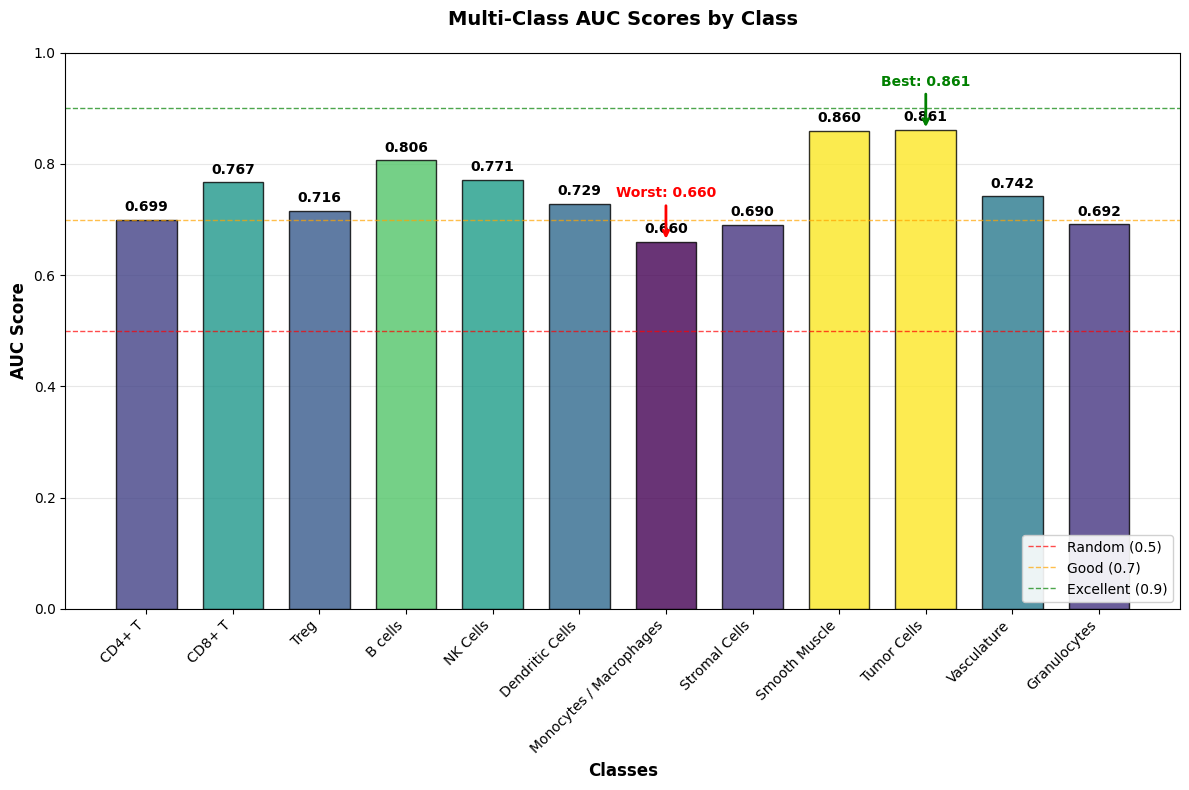

Multi-Class AUC Analysis:
Number of classes: 12
Average AUC: 0.749
Median AUC: 0.735
Standard deviation: 0.063
Min AUC: 0.660 (Class 6)
Max AUC: 0.861 (Class 9)

Performance Distribution:
Excellent (≥0.9): 0 classes
Good (0.7-0.9): 8 classes
Fair (0.5-0.7): 4 classes
Poor (<0.5): 0 classes

Detailed Class Performance:
Class 0: 0.699 (Fair)
Class 1: 0.767 (Good)
Class 2: 0.716 (Good)
Class 3: 0.806 (Good)
Class 4: 0.771 (Good)
Class 5: 0.729 (Good)
Class 6: 0.660 (Fair)
Class 7: 0.690 (Fair)
Class 8: 0.860 (Good)
Class 9: 0.861 (Good)
Class 10: 0.742 (Good)
Class 11: 0.692 (Fair)


In [15]:
multi_class_aucs = used_multi_aucs # metrics_dict['multi_class_aucs']

# Number of classes
n_classes = len(multi_class_aucs)
class_labels = [f'{get_multiclass_ct_name(i)}' for i in range(n_classes)]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create color gradient based on AUC values (higher AUC = darker color)
# Normalize AUC values to [0,1] for color mapping
norm_aucs = np.array(multi_class_aucs)
colors = plt.cm.viridis((norm_aucs - min(norm_aucs)) / (max(norm_aucs) - min(norm_aucs)))

# Set the width of bars and positions
bar_width = 0.7
x_pos = np.arange(n_classes)

# Create bars with color gradient
bars = ax.bar(x_pos, multi_class_aucs, bar_width,
              color=colors, alpha=0.8, edgecolor='black', linewidth=1)

# Customize the plot
ax.set_xlabel('Classes', fontsize=12, fontweight='bold')
ax.set_ylabel('AUC Score', fontsize=12, fontweight='bold')
ax.set_title('Multi-Class AUC Scores by Class',
             fontsize=14, fontweight='bold', pad=20)

# Set x-axis labels and positions
ax.set_xticks(x_pos)
ax.set_xticklabels(class_labels, rotation=45, ha='right')

# Set y-axis limits (AUC scores range from 0 to 1)
ax.set_ylim(0, 1.0)

# Add horizontal reference lines for performance interpretation
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, linewidth=1, label='Random (0.5)')
ax.axhline(y=0.7, color='orange', linestyle='--', alpha=0.7, linewidth=1, label='Good (0.7)')
ax.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, linewidth=1, label='Excellent (0.9)')

# Add legend for reference lines
ax.legend(loc='lower right', framealpha=0.9)

# Add grid for better readability
ax.grid(True, alpha=0.3, axis='y')
ax.set_axisbelow(True)

# Add value labels on top of bars
for i, (bar, auc_value) in enumerate(zip(bars, multi_class_aucs)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
           f'{auc_value:.3f}', ha='center', va='bottom',
           fontsize=10, fontweight='bold')

# Highlight best and worst performing classes
best_class = np.argmax(multi_class_aucs)
worst_class = np.argmin(multi_class_aucs)

# Add annotations for best and worst
ax.annotate(f'Best: {multi_class_aucs[best_class]:.3f}',
            xy=(best_class, multi_class_aucs[best_class]),
            xytext=(best_class, multi_class_aucs[best_class] + 0.08),
            arrowprops=dict(arrowstyle='->', color='green', lw=2),
            fontsize=10, fontweight='bold', color='green', ha='center')

ax.annotate(f'Worst: {multi_class_aucs[worst_class]:.3f}',
            xy=(worst_class, multi_class_aucs[worst_class]),
            xytext=(worst_class, multi_class_aucs[worst_class] + 0.08),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=10, fontweight='bold', color='red', ha='center')

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

# Print detailed statistics
print("Multi-Class AUC Analysis:")
print("=" * 40)
print(f"Number of classes: {n_classes}")
print(f"Average AUC: {np.mean(multi_class_aucs):.3f}")
print(f"Median AUC: {np.median(multi_class_aucs):.3f}")
print(f"Standard deviation: {np.std(multi_class_aucs):.3f}")
print(f"Min AUC: {min(multi_class_aucs):.3f} (Class {worst_class})")
print(f"Max AUC: {max(multi_class_aucs):.3f} (Class {best_class})")

# Performance categories
excellent = sum(1 for auc in multi_class_aucs if auc >= 0.9)
good = sum(1 for auc in multi_class_aucs if 0.7 <= auc < 0.9)
fair = sum(1 for auc in multi_class_aucs if 0.5 <= auc < 0.7)
poor = sum(1 for auc in multi_class_aucs if auc < 0.5)

print(f"\nPerformance Distribution:")
print(f"Excellent (≥0.9): {excellent} classes")
print(f"Good (0.7-0.9): {good} classes")
print(f"Fair (0.5-0.7): {fair} classes")
print(f"Poor (<0.5): {poor} classes")

# List all classes with their performance categories
print(f"\nDetailed Class Performance:")
for i, auc in enumerate(multi_class_aucs):
    if auc >= 0.9:
        category = "Excellent"
    elif auc >= 0.7:
        category = "Good"
    elif auc >= 0.5:
        category = "Fair"
    else:
        category = "Poor"
    print(f"Class {i}: {auc:.3f} ({category})")

In [10]:
from train import create_data_loaders, load_config

In [11]:
config_path = 'C:\\Users\\aqwan\\Documents\\GitHub\\CellSighter\\src\\config_new_more_cts_test.json'

config = load_config(config_path)
train_loader, val_loader = create_data_loaders(config)

Loading training data...
Loaded 5233 training samples
Loading validation data...
Loaded 28101 validation samples
Using data augmentation for training

Training Dataset Statistics:
Total samples: 5233


RuntimeError: Numpy is not available

In [8]:
np.array([560, 102, 12])

array([560, 102,  12])